# Research Question 2
## Sentiment classification on the ParlVote corpus

IMPORT LIBRARIES

In [176]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from afinn import Afinn
import matplotlib.pyplot as plt
from flair.models import TextClassifier
from flair.data import Sentence
from sklearn.utils import shuffle
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
import re

LOAD PARLVOTE_CONCAT.CSV & SET COLUMN NAMES

In [177]:
parlvote = pd.read_csv('ParlVote_concat.csv', header=None)
first_row = parlvote.iloc[0].tolist()
parlvote.columns = first_row
parlvote = parlvote.drop(index=0)
parlvote

,debate_id,motion_speaker_id,motion_speaker_name,motion_party,debate_title,motion_text,speaker_id,speaker_name,party,vote,speech
1,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10105,"Clapham, Michael",labour,0,The right hon Gentleman has recited a catalogu...
2,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10556,"Soley, Clive",labour,0,I am not sure whether this has occurred to the...
3,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10138,"Cox, Tom",labour,0,Before the right hon Gentleman leaves the subj...
4,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10574,"Straw, Jack",labour,0,I thank the right hon Member for Penrith and T...
5,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10239,"Grant, Bernie",labour,0,I thank my right hon Friend for giving way and...
...,...,...,...,...,...,...,...,...,...,...,...
33457,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25361,"Blackford, Ian",scottish-national-party,1,I should point out to the hon Gentleman that E...
33458,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",10354,"Leslie, Chris",independent,1,"On a point of order, Madam Deputy Speaker. I w..."
33459,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25302,"Saville-Roberts, Liz",plaid-cymru,1,"On a point of order, Mr Speaker. Today’s vote ..."
33460,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",24772,"Soubry, Anna",independent,1,"On a point of order, Mr Speaker. I know that ..."


PREPROCESSING TO ONLY HAVE TEXT + SENTIMENT LABEL

In [178]:
import re

def remove_salutation(text):
    # Match and replace 'hon' followed by a space or a dot
    text = re.sub(r'\bhon[ .]', '', text)
    # Match and replace 'Gentleman' or 'gentleman' as a whole word
    text = re.sub(r'\b[Gg]entleman\b', '', text)
    # Match and replace 'Lady' or 'lady' as a whole word
    text = re.sub(r'\b[Ll]ady\b', '', text)
    return text.strip()

# Apply the function to create a new column
parlvote['speech_no_sal'] = parlvote['speech'].apply(remove_salutation)

CREATE SENTIMENT LABELS & ONE-HOT ENCODING

In [179]:
# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
afinn_analyzer = Afinn()
textblob_analyzer = TextBlob

In [180]:
# Define a function to generate the sentiment scores for each row
def generate_sentiment_scores(row):
    text = row['speech']
    
    # Generate VADER sentiment score
    vader_scores = vader_analyzer.polarity_scores(text)['compound']
    
    # Generate Afinn sentiment score
    afinn_score = afinn_analyzer.score(text)
    
    # Generate TextBlob sentiment score
    textblob_score = textblob_analyzer(text).sentiment.polarity
    
    return pd.Series([vader_scores, textblob_score, afinn_score])

In [181]:
# Apply the function to generate sentiment scores for each row and store the scores in new columns
parlvote[['vader', 'textblob', 'afinn']] = parlvote.apply(generate_sentiment_scores, axis=1)

In [182]:
# Define a function to generate the sentiment scores for each row
def generate_sentiment_no_sal(row):
    text = row['speech_no_sal']
    
    # Generate VADER sentiment score
    vader_scores = vader_analyzer.polarity_scores(text)['compound']
    
    # Generate Afinn sentiment score
    afinn_score = afinn_analyzer.score(text)
    
    # Generate TextBlob sentiment score
    textblob_score = textblob_analyzer(text).sentiment.polarity
    
    return pd.Series([vader_scores, textblob_score, afinn_score])

In [183]:
parlvote[['vader_no_sal', 'textblob_no_sal', 'afinn_no_sal']] = parlvote.apply(generate_sentiment_no_sal, axis=1)

In [184]:
parlvote

,debate_id,motion_speaker_id,motion_speaker_name,motion_party,debate_title,motion_text,speaker_id,speaker_name,party,vote,speech,speech_no_sal,vader,textblob,afinn,vader_no_sal,textblob_no_sal,afinn_no_sal
1,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10105,"Clapham, Michael",labour,0,The right hon Gentleman has recited a catalogu...,"The right has recited a catalogue, but, as tw...",-0.8271,-0.045584,-5.0,-0.8271,-0.045584,-5.0
2,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10556,"Soley, Clive",labour,0,I am not sure whether this has occurred to the...,I am not sure whether this has occurred to the...,-0.9973,0.104839,-75.0,-0.9973,0.104839,-75.0
3,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10138,"Cox, Tom",labour,0,Before the right hon Gentleman leaves the subj...,Before the right leaves the subject of prison...,-0.9993,0.106905,-137.0,-0.9993,0.106905,-137.0
4,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10574,"Straw, Jack",labour,0,I thank the right hon Member for Penrith and T...,I thank the right Member for Penrith and The B...,-0.9978,0.089524,-129.0,-0.9978,0.089524,-129.0
5,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10239,"Grant, Bernie",labour,0,I thank my right hon Friend for giving way and...,I thank my right Friend for giving way and con...,0.8878,0.246825,0.0,0.8878,0.246825,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33457,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25361,"Blackford, Ian",scottish-national-party,1,I should point out to the hon Gentleman that E...,I should point out to the that EU nationals a...,-0.3291,-0.800000,-3.0,-0.3291,-0.800000,-3.0
33458,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",10354,"Leslie, Chris",independent,1,"On a point of order, Madam Deputy Speaker. I w...","On a point of order, Madam Deputy Speaker. I w...",0.7783,0.000000,5.0,0.7783,0.000000,5.0
33459,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25302,"Saville-Roberts, Liz",plaid-cymru,1,"On a point of order, Mr Speaker. Today’s vote ...","On a point of order, Mr Speaker. Today’s vote ...",0.3818,-0.101389,1.0,0.3818,-0.101389,1.0
33460,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",24772,"Soubry, Anna",independent,1,"On a point of order, Mr Speaker. I know that ...","On a point of order, Mr Speaker. I know that ...",-0.1235,0.110714,-1.0,-0.1235,0.110714,-1.0


CONVERT SCORES TO 'POSITIVE', 'NEUTRAL' OR 'NEGATIVE'

In [185]:
# Define a function to convert VADER sentiment scores to labels
def vader_score_to_label(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Define a function to convert TextBlob sentiment scores to labels
def textblob_score_to_label(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

# Define a function to convert Afinn sentiment scores to labels
def afinn_score_to_label(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [186]:
# Apply the label conversion functions to the sentiment score columns
parlvote['vader'] = parlvote['vader'].apply(vader_score_to_label)
parlvote['textblob'] = parlvote['textblob'].apply(textblob_score_to_label)
parlvote['afinn'] = parlvote['afinn'].apply(afinn_score_to_label)

parlvote['vader_no_sal'] = parlvote['vader_no_sal'].apply(vader_score_to_label)
parlvote['textblob_no_sal'] = parlvote['textblob_no_sal'].apply(textblob_score_to_label)
parlvote['afinn_no_sal'] = parlvote['afinn_no_sal'].apply(afinn_score_to_label)

In [187]:
parlvote

,debate_id,motion_speaker_id,motion_speaker_name,motion_party,debate_title,motion_text,speaker_id,speaker_name,party,vote,speech,speech_no_sal,vader,textblob,afinn,vader_no_sal,textblob_no_sal,afinn_no_sal
1,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10105,"Clapham, Michael",labour,0,The right hon Gentleman has recited a catalogu...,"The right has recited a catalogue, but, as tw...",Negative,Negative,Negative,Negative,Negative,Negative
2,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10556,"Soley, Clive",labour,0,I am not sure whether this has occurred to the...,I am not sure whether this has occurred to the...,Negative,Positive,Negative,Negative,Positive,Negative
3,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10138,"Cox, Tom",labour,0,Before the right hon Gentleman leaves the subj...,Before the right leaves the subject of prison...,Negative,Positive,Negative,Negative,Positive,Negative
4,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10574,"Straw, Jack",labour,0,I thank the right hon Member for Penrith and T...,I thank the right Member for Penrith and The B...,Negative,Positive,Negative,Negative,Positive,Negative
5,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10239,"Grant, Bernie",labour,0,I thank my right hon Friend for giving way and...,I thank my right Friend for giving way and con...,Positive,Positive,Neutral,Positive,Positive,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33457,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25361,"Blackford, Ian",scottish-national-party,1,I should point out to the hon Gentleman that E...,I should point out to the that EU nationals a...,Negative,Negative,Negative,Negative,Negative,Negative
33458,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",10354,"Leslie, Chris",independent,1,"On a point of order, Madam Deputy Speaker. I w...","On a point of order, Madam Deputy Speaker. I w...",Positive,Neutral,Positive,Positive,Neutral,Positive
33459,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25302,"Saville-Roberts, Liz",plaid-cymru,1,"On a point of order, Mr Speaker. Today’s vote ...","On a point of order, Mr Speaker. Today’s vote ...",Positive,Negative,Positive,Positive,Negative,Positive
33460,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",24772,"Soubry, Anna",independent,1,"On a point of order, Mr Speaker. I know that ...","On a point of order, Mr Speaker. I know that ...",Negative,Positive,Negative,Negative,Positive,Negative


CHECK THE NUMBER OF 'NEUTRAL' SCORES & REMOVE THESE INSTANCES

In [188]:
def compute_label_counts(df):
    # Compute label counts for each sentiment analysis tool + vote column
    vader_counts = df['vader'].value_counts()
    vader_no_sal_counts = df['vader_no_sal'].value_counts()
    textblob_counts = df['textblob'].value_counts()
    textblob_no_sal_counts = df['textblob_no_sal'].value_counts()
    afinn_counts = df['afinn'].value_counts()
    afinn_no_sal_counts = df['afinn_no_sal'].value_counts()

    # Compute total number of rows with 'Neutral' label in one or more columns
    neutral_rows = df[(df['vader'] == 'Neutral') | (df['textblob'] == 'Neutral') | (df['afinn'] == 'Neutral')].shape[0]
    neutral_rows_no_sal = df[(df['vader_no_sal'] == 'Neutral') | (df['textblob_no_sal'] == 'Neutral') | (df['afinn_no_sal'] == 'Neutral')].shape[0]

    # Compute overlap between labels in different columns
    positive_overlap = len(set(df[(df['vader'] == 'Positive') & (df['textblob'] == 'Positive') & (df['afinn'] == 'Positive')].index))
    negative_overlap = len(set(df[(df['vader'] == 'Negative') & (df['textblob'] == 'Negative') & (df['afinn'] == 'Negative')].index))
    neutral_overlap = len(set(df[(df['vader'] == 'Neutral') & (df['textblob'] == 'Neutral') & (df['afinn'] == 'Neutral')].index))
    partly_neutral_overlap = len(set(df[(df['vader'] == 'Neutral') | (df['textblob'] == 'Neutral') | (df['afinn'] == 'Neutral')].index))

    # Compute overlap between labels in different columns (NO SAL)
    positive_overlap_no_sal = len(set(df[(df['vader_no_sal'] == 'Positive') & (df['textblob_no_sal'] == 'Positive') & (df['afinn_no_sal'] == 'Positive')].index))
    negative_overlap_no_sal = len(set(df[(df['vader_no_sal'] == 'Negative') & (df['textblob_no_sal'] == 'Negative') & (df['afinn_no_sal'] == 'Negative')].index))
    neutral_overlap_no_sal = len(set(df[(df['vader_no_sal'] == 'Neutral') & (df['textblob_no_sal'] == 'Neutral') & (df['afinn_no_sal'] == 'Neutral')].index))
    partly_neutral_overlap_no_sal = len(set(df[(df['vader_no_sal'] == 'Neutral') | (df['textblob_no_sal'] == 'Neutral') | (df['afinn_no_sal'] == 'Neutral')].index))


    # Return label counts and overlap as a dictionary
    return {
        'vader_counts': vader_counts,
        'vader_no_sal_counts': vader_no_sal_counts,
        'textblob_counts': textblob_counts,
        'textblob_no_sal_counts': textblob_no_sal_counts,
        'afinn_counts': afinn_counts,
        'afinn_no_sal_counts': afinn_no_sal_counts,
        'neutral_rows': neutral_rows,
        'positive_overlap': positive_overlap,
        'negative_overlap': negative_overlap,
        'neutral_overlap': neutral_overlap,
        'partly_neutral_overlap': partly_neutral_overlap, 
        'neutral_rows_no_sal': neutral_rows_no_sal,
        'positive_overlap_no_sal': positive_overlap_no_sal,
        'negative_overlap_no_sal': negative_overlap_no_sal,
        'neutral_overlap_no_sal': neutral_overlap_no_sal,
        'partly_neutral_overlap_no_sal': partly_neutral_overlap_no_sal
    }

# Call the function to compute label counts and overlap
label_counts = compute_label_counts(parlvote)

In [189]:
# Print the label counts and overlap
print("Label counts:")
print("VADER:\n", label_counts['vader_counts'])
print("VADER (no sal):\n", label_counts['vader_no_sal_counts'])
print("TextBlob:\n", label_counts['textblob_counts'])
print("TextBlob (no sal):\n", label_counts['textblob_no_sal_counts'])
print("Afinn:\n", label_counts['afinn_counts'])
print("Afinn (no sal):\n", label_counts['afinn_no_sal_counts'])
print("Value counts: \n", parlvote['vote'].value_counts())

Label counts:
VADER:
 Positive    25884
Negative     6357
Neutral      1220
Name: vader, dtype: int64
VADER (no sal):
 Positive    25873
Negative     6369
Neutral      1219
Name: vader_no_sal, dtype: int64
TextBlob:
 Positive    28793
Negative     3184
Neutral      1484
Name: textblob, dtype: int64
TextBlob (no sal):
 Positive    28793
Negative     3184
Neutral      1484
Name: textblob_no_sal, dtype: int64
Afinn:
 Positive    23379
Negative     7893
Neutral      2189
Name: afinn, dtype: int64
Afinn (no sal):
 Positive    23379
Negative     7893
Neutral      2189
Name: afinn_no_sal, dtype: int64
Value counts: 
 1    17721
0    15740
Name: vote, dtype: int64


In [190]:
print("Total number of rows with 'Neutral' label in one or more columns:", label_counts['neutral_rows'])
print("Overlap between 'Positive' labels:", label_counts['positive_overlap'])
print("Overlap between 'Negative' labels:", label_counts['negative_overlap'])
print("Overlap between 'Neutral' labels:", label_counts['neutral_overlap'])
print("Partly overlap between 'Neutral' labels:", label_counts['partly_neutral_overlap'])

Total number of rows with 'Neutral' label in one or more columns: 3317
Overlap between 'Positive' labels: 20591
Overlap between 'Negative' labels: 1213
Overlap between 'Neutral' labels: 549
Partly overlap between 'Neutral' labels: 3317


In [191]:
print("Total number of rows with 'Neutral' label in one or more columns:", label_counts['neutral_rows_no_sal'])
print("Overlap between 'Positive' labels:", label_counts['positive_overlap_no_sal'])
print("Overlap between 'Negative' labels:", label_counts['negative_overlap_no_sal'])
print("Overlap between 'Neutral' labels:", label_counts['neutral_overlap_no_sal'])
print("Partly overlap between 'Neutral' labels:", label_counts['partly_neutral_overlap_no_sal'])

Total number of rows with 'Neutral' label in one or more columns: 3317
Overlap between 'Positive' labels: 20581
Overlap between 'Negative' labels: 1212
Overlap between 'Neutral' labels: 549
Partly overlap between 'Neutral' labels: 3317


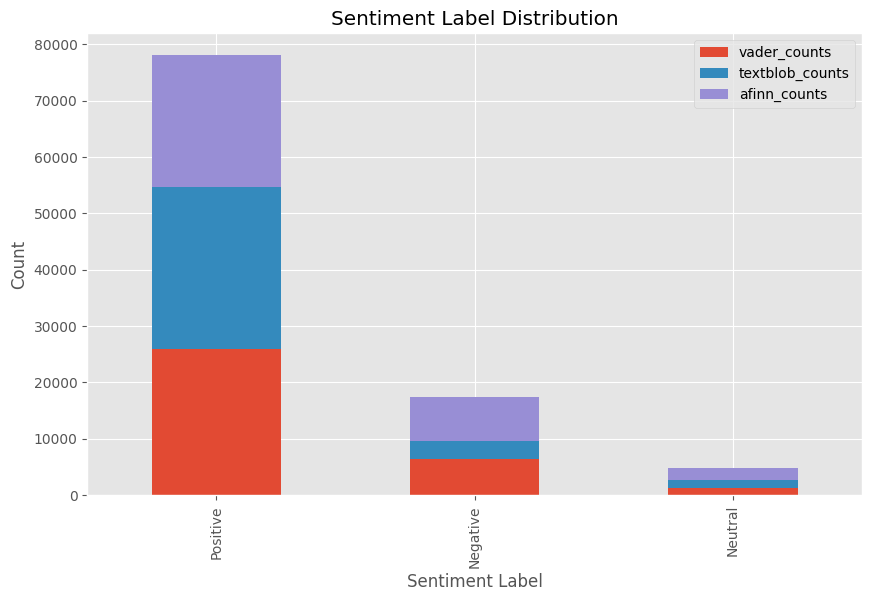

In [192]:
# Plot the label counts as a stacked bar chart
plt.style.use('ggplot')
label_counts_df = pd.DataFrame(label_counts)
label_counts_df[['vader_counts', 'textblob_counts', 'afinn_counts']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment Label Distribution')
plt.show()

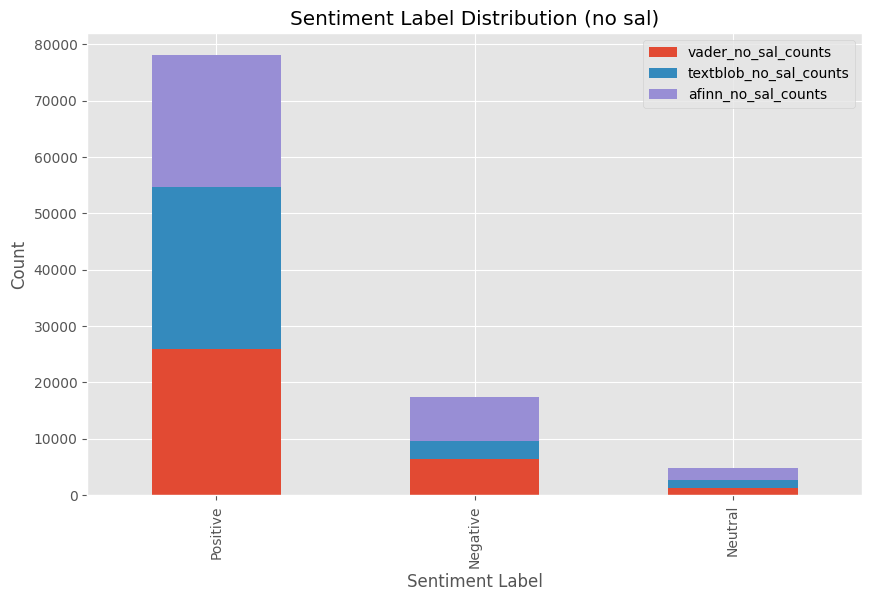

In [193]:
# Plot the label counts as a stacked bar chart
plt.style.use('ggplot')
label_counts_df = pd.DataFrame(label_counts)
label_counts_df[['vader_no_sal_counts', 'textblob_no_sal_counts', 'afinn_no_sal_counts']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment Label Distribution (no sal)')
plt.show()

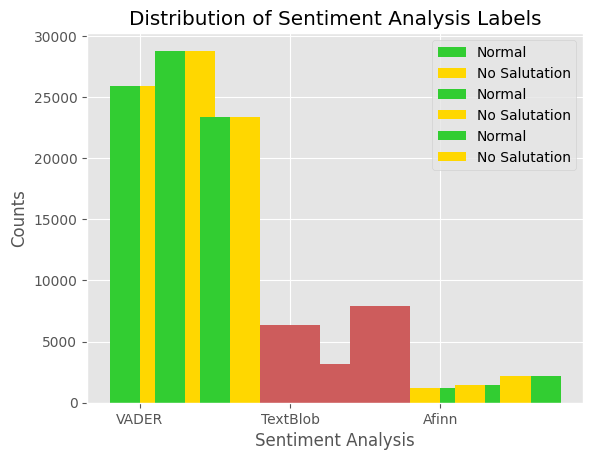

In [194]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and colors
labels = ['Positive', 'Negative', 'Neutral']
colors = ['limegreen', 'indianred', 'gold']

# Define the data to plot
data = [
    [
        [parlvote['vader'].value_counts()[label] for label in labels],
        [parlvote['vader_no_sal'].value_counts()[label] for label in labels]
    ],
    [
        [parlvote['textblob'].value_counts()[label] for label in labels],
        [parlvote['textblob_no_sal'].value_counts()[label] for label in labels]
    ],
    [
        [parlvote['afinn'].value_counts()[label] for label in labels],
        [parlvote['afinn_no_sal'].value_counts()[label] for label in labels]
    ]
]

# Set the width of each bar and the distance between the bars
bar_width = 0.2
bar_distance = 0.1

# Set the x values
x = np.arange(len(labels))

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the bars
for i in range(len(data)):
    ax.bar(x + (i * (bar_width + bar_distance)), data[i][0], width=bar_width, color=colors, label='Normal')
    ax.bar(x + (i * (bar_width + bar_distance)) + bar_width, data[i][1], width=bar_width, color=colors[::-1], label='No Salutation')

# Set the x and y axis labels, title, and legend
ax.set_xlabel('Sentiment Analysis')
ax.set_ylabel('Counts')
ax.set_title('Distribution of Sentiment Analysis Labels')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(['VADER', 'TextBlob', 'Afinn'])
ax.legend()

# Show the plot
plt.show()

REMOVE NEUTRAL ROWS

In [310]:
# remove instances where a row contains 'neutral'
pv = parlvote.loc[~((parlvote['vader'] == 'Neutral') | (parlvote['textblob'] == 'Neutral') | (parlvote['afinn'] == 'Neutral'))]
# Create a copy of the DataFrame to avoid modifying the original DataFrame
pv = pv.copy()

In [311]:
pv['vote'].value_counts()

1    15863
0    14281
Name: vote, dtype: int64

In [196]:
# remove instances where a row contains 'neutral'
pv_no_sal = parlvote.loc[~((parlvote['vader_no_sal'] == 'Neutral') | (parlvote['textblob_no_sal'] == 'Neutral') | (parlvote['afinn_no_sal'] == 'Neutral'))]
# Create a copy of the DataFrame to avoid modifying the original DataFrame
pv_no_sal = pv_no_sal.copy()

In [197]:
# Print the resulting description of dataframe to verify that the rows were removed
pv.describe()

,debate_id,motion_speaker_id,motion_speaker_name,motion_party,debate_title,motion_text,speaker_id,speaker_name,party,vote,speech,speech_no_sal,vader,textblob,afinn,vader_no_sal,textblob_no_sal,afinn_no_sal
count,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144
unique,1985,549,549,13,1796,1143,1340,1336,16,2,30142,30142,2,2,2,3,2,2
top,2015-12-02d.323.0,10354,"Leslie, Chris",labour,Local Government Finance,"I beg to move, That the clause be read a Secon...",10499,"Redwood, John",conservative,1,Shocking.,Shocking.,Positive,Positive,Positive,Positive,Positive,Positive
freq,138,749,749,15280,238,4468,260,260,12330,15863,2,2,24408,27369,22663,24397,27369,22663


In [198]:
pv_no_sal.describe()

,debate_id,motion_speaker_id,motion_speaker_name,motion_party,debate_title,motion_text,speaker_id,speaker_name,party,vote,speech,speech_no_sal,vader,textblob,afinn,vader_no_sal,textblob_no_sal,afinn_no_sal
count,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144,30144
unique,1985,549,549,13,1796,1143,1340,1336,16,2,30142,30142,3,2,2,2,2,2
top,2015-12-02d.323.0,10354,"Leslie, Chris",labour,Local Government Finance,"I beg to move, That the clause be read a Secon...",10499,"Redwood, John",conservative,1,Good.,Good.,Positive,Positive,Positive,Positive,Positive,Positive
freq,138,748,748,15281,238,4468,260,260,12331,15864,2,2,24406,27369,22662,24397,27369,22662


In [199]:
def compute_counts_2nd(df):
    # Compute label counts for each sentiment analysis tool
    vader_counts = df['vader'].value_counts()
    textblob_counts = df['textblob'].value_counts()
    afinn_counts = df['afinn'].value_counts()
    vote_counts = df['vote'].value_counts()

    # Compute overlap between labels in different columns
    positive_overlap = len(set(df[(df['vader'] == 'Positive') & (df['textblob'] == 'Positive') & (df['afinn'] == 'Positive')].index))
    negative_overlap = len(set(df[(df['vader'] == 'Negative') & (df['textblob'] == 'Negative') & (df['afinn'] == 'Negative')].index))

    vote_vader_positive = len(set(df[(df['vader'] == 'Positive') & (df['vote'] == '1')].index))
    vote_vader_negative = len(set(df[(df['vader'] == 'Negative') & (df['vote'] == '0')].index))
    vote_textblob_positive = len(set(df[(df['textblob'] == 'Positive') & (df['vote'] == '1')].index))
    vote_textblob_negative = len(set(df[(df['textblob'] == 'Negative') & (df['vote'] == '0')].index))
    vote_afinn_positive = len(set(df[(df['afinn'] == 'Positive') & (df['vote'] == '1')].index))
    vote_afinn_negative = len(set(df[(df['afinn'] == 'Negative') & (df['vote'] == '0')].index))

    # Return label counts and overlap as a dictionary
    return {
        'vader_counts': vader_counts,
        'textblob_counts': textblob_counts,
        'afinn_counts': afinn_counts,
        'vote_counts': vote_counts,
        'positive_overlap': positive_overlap,
        'negative_overlap': negative_overlap,
        'vote_vader_positive': vote_vader_positive, 
        'vote_vader_negative': vote_vader_negative, 
        'vote_textblob_positive': vote_textblob_positive, 
        'vote_textblob_negative': vote_textblob_negative, 
        'vote_afinn_positive': vote_afinn_positive, 
        'vote_afinn_negative': vote_afinn_negative
    }


In [200]:
def compute_counts_2nd_no_sal(df):
    # Compute label counts for each sentiment analysis tool
    vader_counts = df['vader_no_sal'].value_counts()
    textblob_counts = df['textblob_no_sal'].value_counts()
    afinn_counts = df['afinn_no_sal'].value_counts()
    vote_counts = df['vote'].value_counts()

    # Compute overlap between labels in different columns
    positive_overlap = len(set(df[(df['vader_no_sal'] == 'Positive') & (df['textblob_no_sal'] == 'Positive') & (df['afinn_no_sal'] == 'Positive')].index))
    negative_overlap = len(set(df[(df['vader_no_sal'] == 'Negative') & (df['textblob_no_sal'] == 'Negative') & (df['afinn_no_sal'] == 'Negative')].index))

    vote_vader_positive = len(set(df[(df['vader_no_sal'] == 'Positive') & (df['vote'] == '1')].index))
    vote_vader_negative = len(set(df[(df['vader_no_sal'] == 'Negative') & (df['vote'] == '0')].index))
    vote_textblob_positive = len(set(df[(df['textblob_no_sal'] == 'Positive') & (df['vote'] == '1')].index))
    vote_textblob_negative = len(set(df[(df['textblob_no_sal'] == 'Negative') & (df['vote'] == '0')].index))
    vote_afinn_positive = len(set(df[(df['afinn_no_sal'] == 'Positive') & (df['vote'] == '1')].index))
    vote_afinn_negative = len(set(df[(df['afinn_no_sal'] == 'Negative') & (df['vote'] == '0')].index))

    # Return label counts and overlap as a dictionary
    return {
        'vader_counts': vader_counts,
        'textblob_counts': textblob_counts,
        'afinn_counts': afinn_counts,
        'vote_counts': vote_counts,
        'positive_overlap': positive_overlap,
        'negative_overlap': negative_overlap,
        'vote_vader_positive': vote_vader_positive, 
        'vote_vader_negative': vote_vader_negative, 
        'vote_textblob_positive': vote_textblob_positive, 
        'vote_textblob_negative': vote_textblob_negative, 
        'vote_afinn_positive': vote_afinn_positive, 
        'vote_afinn_negative': vote_afinn_negative
    }


In [201]:
# Call the function to compute label overlap between sentiment analysis and vote columns
label_overlap = compute_counts_2nd(pv)
label_overlap_no_sal = compute_counts_2nd_no_sal(pv_no_sal)

In [202]:
# Print the label counts and overlap for the data INCLUDING SALUTIONS
print("Label counts:")
print("VADER:\n", label_overlap['vader_counts'])
print("TextBlob:\n", label_overlap['textblob_counts'])
print("Afinn:\n", label_overlap['afinn_counts'])
print("Vote:\n", label_overlap['vote_counts'])
print("Overlap between 'Positive' labels:", label_overlap['positive_overlap'])
print("Overlap between 'Negative' labels:", label_overlap['negative_overlap'])
print("Vader/Vote overlap 'Positive' labels:", label_overlap['vote_vader_positive'])
print("Vader/Vote overlap 'Negative' labels:", label_overlap['vote_vader_negative'])
print("Textblob/Vote overlap 'Positive' labels:", label_overlap['vote_textblob_positive'])
print("Textblob/Vote overlap 'Negative' labels:", label_overlap['vote_textblob_negative'])
print("Afinn/Vote overlap 'Positive' labels:", label_overlap['vote_afinn_positive'])
print("Afinn/Vote overlap 'Negative' labels:", label_overlap['vote_afinn_negative'])

Label counts:
VADER:
 Positive    24408
Negative     5736
Name: vader, dtype: int64
TextBlob:
 Positive    27369
Negative     2775
Name: textblob, dtype: int64
Afinn:
 Positive    22663
Negative     7481
Name: afinn, dtype: int64
Vote:
 1    15863
0    14281
Name: vote, dtype: int64
Overlap between 'Positive' labels: 20591
Overlap between 'Negative' labels: 1213
Vader/Vote overlap 'Positive' labels: 12722
Vader/Vote overlap 'Negative' labels: 2595
Textblob/Vote overlap 'Positive' labels: 14316
Textblob/Vote overlap 'Negative' labels: 1228
Afinn/Vote overlap 'Positive' labels: 11735
Afinn/Vote overlap 'Negative' labels: 3353


In [203]:
# Print the label counts and overlap for the data EXCLUDING SALUTIONS
print("Label counts:")
print("VADER:\n", label_overlap_no_sal['vader_counts'])
print("TextBlob:\n", label_overlap_no_sal['textblob_counts'])
print("Afinn:\n", label_overlap_no_sal['afinn_counts'])
print("Vote:\n", label_overlap_no_sal['vote_counts'])
print("Overlap between 'Positive' labels:", label_overlap_no_sal['positive_overlap'])
print("Overlap between 'Negative' labels:", label_overlap_no_sal['negative_overlap'])
print("Vader/Vote overlap 'Positive' labels:", label_overlap_no_sal['vote_vader_positive'])
print("Vader/Vote overlap 'Negative' labels:", label_overlap_no_sal['vote_vader_negative'])
print("Textblob/Vote overlap 'Positive' labels:", label_overlap_no_sal['vote_textblob_positive'])
print("Textblob/Vote overlap 'Negative' labels:", label_overlap_no_sal['vote_textblob_negative'])
print("Afinn/Vote overlap 'Positive' labels:", label_overlap_no_sal['vote_afinn_positive'])
print("Afinn/Vote overlap 'Negative' labels:", label_overlap_no_sal['vote_afinn_negative'])

Label counts:
VADER:
 Positive    24397
Negative     5747
Name: vader_no_sal, dtype: int64
TextBlob:
 Positive    27369
Negative     2775
Name: textblob_no_sal, dtype: int64
Afinn:
 Positive    22662
Negative     7482
Name: afinn_no_sal, dtype: int64
Vote:
 1    15864
0    14280
Name: vote, dtype: int64
Overlap between 'Positive' labels: 20581
Overlap between 'Negative' labels: 1212
Vader/Vote overlap 'Positive' labels: 12718
Vader/Vote overlap 'Negative' labels: 2601
Textblob/Vote overlap 'Positive' labels: 14317
Textblob/Vote overlap 'Negative' labels: 1228
Afinn/Vote overlap 'Positive' labels: 11735
Afinn/Vote overlap 'Negative' labels: 3353


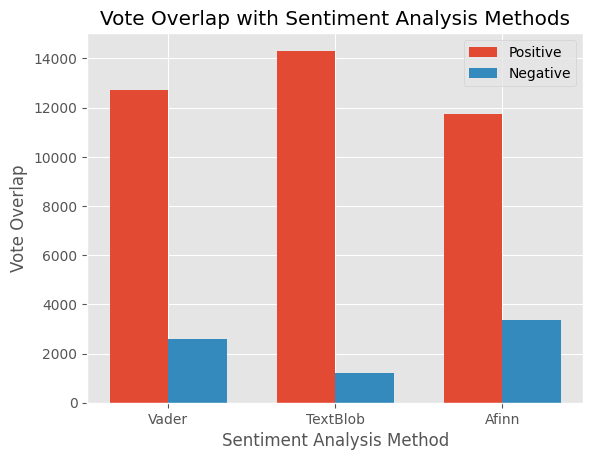

In [204]:
# Create bar chart for data INCLUDING SALUTATIONS
x = np.arange(3)
width = 0.35
fig, ax = plt.subplots()
positive_bars = ax.bar(x - width/2, [label_overlap['vote_vader_positive'], label_overlap['vote_textblob_positive'], label_overlap['vote_afinn_positive']], width, label='Positive')
negative_bars = ax.bar(x + width/2, [label_overlap['vote_vader_negative'], label_overlap['vote_textblob_negative'], label_overlap['vote_afinn_negative']], width, label='Negative')

# Add labels and title to chart
ax.set_xticks(x)
ax.set_xticklabels(['Vader', 'TextBlob', 'Afinn'])
ax.set_xlabel('Sentiment Analysis Method')
ax.set_ylabel('Vote Overlap')
ax.set_title('Vote Overlap with Sentiment Analysis Methods')

# Add legend to chart
ax.legend()

# Show the chart
plt.show()

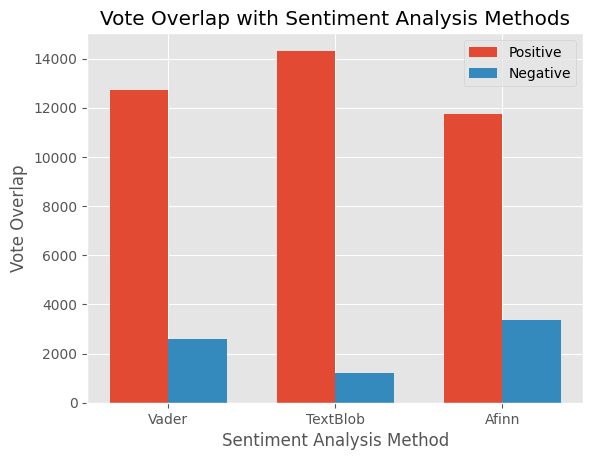

In [205]:
# Create bar chart for data EXCLUDING SALUTATIONS
x = np.arange(3)
width = 0.35
fig, ax = plt.subplots()
positive_bars = ax.bar(x - width/2, [label_overlap_no_sal['vote_vader_positive'], label_overlap_no_sal['vote_textblob_positive'], label_overlap_no_sal['vote_afinn_positive']], width, label='Positive')
negative_bars = ax.bar(x + width/2, [label_overlap_no_sal['vote_vader_negative'], label_overlap_no_sal['vote_textblob_negative'], label_overlap_no_sal['vote_afinn_negative']], width, label='Negative')

# Add labels and title to chart
ax.set_xticks(x)
ax.set_xticklabels(['Vader', 'TextBlob', 'Afinn'])
ax.set_xlabel('Sentiment Analysis Method')
ax.set_ylabel('Vote Overlap')
ax.set_title('Vote Overlap with Sentiment Analysis Methods')

# Add legend to chart
ax.legend()

# Show the chart
plt.show()

ONE-HOT ENCODE SENTIMENT LABELS

In [312]:
def label_to_binary(label):
    if label == 'Positive':
        return 1
    else:
        return 0

# Convert sentiment labels to binary values for 'vader', 'textblob', and 'afinn' columns
pv['vader'] = pv['vader'].apply(label_to_binary)
pv['textblob'] = pv['textblob'].apply(label_to_binary)
pv['afinn'] = pv['afinn'].apply(label_to_binary)

In [308]:
def str_to_int(label):
    if label == '1':
        return 1
    else:
        return 0

pv['vote'] = pv['vote'].apply(str_to_int)

In [315]:
pv['vote'].value_counts()

1    15863
0    14281
Name: vote, dtype: int64

In [316]:
print(pv['vote'].dtype)
print(pv['vader'].dtype)
print(pv['textblob'].dtype)
print(pv['afinn'].dtype)

int64
int64
int64
int64


In [207]:
pv

,debate_id,motion_speaker_id,motion_speaker_name,motion_party,debate_title,motion_text,speaker_id,speaker_name,party,vote,speech,speech_no_sal,vader,textblob,afinn,vader_no_sal,textblob_no_sal,afinn_no_sal
1,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10105,"Clapham, Michael",labour,0,The right hon Gentleman has recited a catalogu...,"The right has recited a catalogue, but, as tw...",0,0,0,Negative,Negative,Negative
2,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10556,"Soley, Clive",labour,0,I am not sure whether this has occurred to the...,I am not sure whether this has occurred to the...,0,1,0,Negative,Positive,Negative
3,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10138,"Cox, Tom",labour,0,Before the right hon Gentleman leaves the subj...,Before the right leaves the subject of prison...,0,1,0,Negative,Positive,Negative
4,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10574,"Straw, Jack",labour,0,I thank the right hon Member for Penrith and T...,I thank the right Member for Penrith and The B...,0,1,0,Negative,Positive,Negative
6,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10132,"Corbett, Robin",labour,0,While I acknowledge that the number of police ...,While I acknowledge that the number of police ...,0,0,0,Negative,Negative,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33456,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",10193,"Fabricant, Michael",conservative,0,"Is my hon Friend aware that, if the marvellous...","Is my Friend aware that, if the marvellous Lau...",1,1,1,Positive,Positive,Positive
33457,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25361,"Blackford, Ian",scottish-national-party,1,I should point out to the hon Gentleman that E...,I should point out to the that EU nationals a...,0,0,0,Negative,Negative,Negative
33459,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25302,"Saville-Roberts, Liz",plaid-cymru,1,"On a point of order, Mr Speaker. Today’s vote ...","On a point of order, Mr Speaker. Today’s vote ...",1,0,1,Positive,Negative,Positive
33460,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",24772,"Soubry, Anna",independent,1,"On a point of order, Mr Speaker. I know that ...","On a point of order, Mr Speaker. I know that ...",0,1,0,Negative,Positive,Negative


In [317]:
# Define a function to one-hot encode a column
def one_hot_encode(df, column):
    df[column + '_positive'] = (df[column] == 1).astype(int)
    df[column + '_negative'] = (df[column] == 0).astype(int)
    return df

# Apply the function to one-hot encode the columns in the 'pv' dataframe
pv = one_hot_encode(pv, 'vote')
pv = one_hot_encode(pv, 'vader')
pv = one_hot_encode(pv, 'textblob')
pv = one_hot_encode(pv, 'afinn')


In [278]:
# Print the resulting dataframe
pv

,debate_id,motion_speaker_id,motion_speaker_name,motion_party,debate_title,motion_text,speaker_id,speaker_name,party,speech,...,textblob_no_sal,afinn_no_sal,vote_positive,vote_negative,vader_positive,vader_negative,textblob_positive,textblob_negative,afinn_positive,afinn_negative
1,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10105,"Clapham, Michael",labour,The right hon Gentleman has recited a catalogu...,...,Negative,Negative,0,1,0,1,0,1,0,1
2,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10556,"Soley, Clive",labour,I am not sure whether this has occurred to the...,...,Positive,Negative,0,1,0,1,1,0,0,1
3,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10138,"Cox, Tom",labour,Before the right hon Gentleman leaves the subj...,...,Positive,Negative,0,1,0,1,1,0,0,1
4,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10574,"Straw, Jack",labour,I thank the right hon Member for Penrith and T...,...,Positive,Negative,0,1,0,1,1,0,0,1
6,1997-05-19a.379.7,10394,"Maclean, David",conservative,Orders of the Day — Home Affairs,I beg to move as an amendment to the Address t...,10132,"Corbett, Robin",labour,While I acknowledge that the number of police ...,...,Negative,Negative,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33456,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",10193,"Fabricant, Michael",conservative,"Is my hon Friend aware that, if the marvellous...",...,Positive,Positive,0,1,1,0,1,0,1,0
33457,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25361,"Blackford, Ian",scottish-national-party,I should point out to the hon Gentleman that E...,...,Negative,Negative,0,1,0,1,0,1,0,1
33459,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",25302,"Saville-Roberts, Liz",plaid-cymru,"On a point of order, Mr Speaker. Today’s vote ...",...,Negative,Positive,0,1,1,0,0,1,1,0
33460,2019-10-29b.290.3,25432,"Smith, Cat",labour,Early parliamentary general election,"I beg to move amendment 2, page 1, line 2, lea...",24772,"Soubry, Anna",independent,"On a point of order, Mr Speaker. I know that ...",...,Positive,Negative,0,1,0,1,1,0,0,1


PREPROCESSING FOR BiLSTM  
1 - There is no preprocessing necessary when you use BERT base cased. Why? Because this differentiates between the cased and uncased versions 'Gentleman' and 'gentleman'.  

In [210]:
# Remove all instances of 'Honourable Gentleman'
count_gentleman_cased = pv['speech'].str.count('Gentleman').sum()
count_gentleman_uncased = pv['speech'].str.count('gentleman').sum()

count_lady_cased = pv['speech'].str.count('Lady').sum()
count_lady_uncased = pv['speech'].str.count('lady').sum()

count_hon_cased = pv['speech'].str.count('Hon').sum()
count_hon_uncased = pv['speech'].str.count('hon').sum()

count_honourable_cased = pv['speech'].str.count('Honourable').sum()
count_honourable_uncased = pv['speech'].str.count('honourable').sum()

count_hg = pv['speech'].str.count('hon Gentleman').sum()
count_hl = pv['speech'].str.count('hon Lady').sum()

In [211]:
print(f"'Gentleman' appears {count_gentleman_cased} times in the 'speech' column.")
print(f"'gentleman' appears {count_gentleman_uncased} times in the 'speech' column.")
print(f"'Lady' appears {count_lady_cased} times in the 'speech' column.")
print(f"'lady' appears {count_lady_uncased} times in the 'speech' column.")
print(f"'Hon' appears {count_hon_cased} times in the 'speech' column.")
print(f"'hon' appears {count_hon_uncased} times in the 'speech' column.")
print(f"'Honourable' appears {count_honourable_cased} times in the 'speech' column.")
print(f"'honourable' appears {count_honourable_uncased} times in the 'speech' column.")

print(f"'hon Gentleman' appears {count_hg} times in the 'speech' column.")
print(f"'hon Lady' appears {count_hl} times in the 'speech' column.")

'Gentleman' appears 32565 times in the 'speech' column.
'gentleman' appears 209 times in the 'speech' column.
'Lady' appears 8045 times in the 'speech' column.
'lady' appears 264 times in the 'speech' column.
'Hon' appears 1207 times in the 'speech' column.
'hon' appears 146675 times in the 'speech' column.
'Honourable' appears 6 times in the 'speech' column.
'honourable' appears 435 times in the 'speech' column.
'hon Gentleman' appears 31536 times in the 'speech' column.
'hon Lady' appears 7564 times in the 'speech' column.


Check for max size

In [ ]:
!pip install transformers

import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def check_max_size(df, column_name, max_size):
    exceeds_max_size = False

    for text in df[column_name]:
        token_count = len(tokenizer.tokenize(text))
        if token_count > max_size:
            exceeds_max_size = True
            print(f"Text with length {token_count} exceeds the max size of {max_size}.")
            break

    if not exceeds_max_size:
        print(f"All texts in the '{column_name}' column are within the max size of {max_size}.")

In [224]:
max_size = 512  # BERT's max input size
check_max_size(pv, 'speech', max_size)

Text with length 3385 exceeds the max size of 512.


SETUP FOR EXPERIMENTS

In [226]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import BertTokenizer, TFBertModel
from sentence_transformers import SentenceTransformer

Take a small sample for testing purposes

In [319]:
# Take a random sample of 1000 rows from 'pv'
pv_sample = pv.sample(n=1000, random_state=42)

Create train-test split

In [228]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [320]:
def prepare_data(df, input_column, label_columns, test_size=0.2, random_state=None):
    # Split the data into train and test sets
    train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Extract the input text and labels for train and test sets
    X_train = train_data[input_column].tolist()
    X_test = test_data[input_column].tolist()
    y_train = train_data[label_columns].values
    y_test = test_data[label_columns].values
    
    return X_train, y_train, X_test, y_test

In [321]:
# Set the input column name and the one-hot encoded label column names
input_column = 'speech'  
label_columns = ['vote_positive', 'vote_negative', 'vader_positive', 'vader_negative', 'textblob_positive', 'textblob_negative', 'afinn_positive', 'afinn_negative']

# Generate the train/test split
X_train, y_train, X_test, y_test = prepare_data(pv_sample, input_column, label_columns, test_size=0.2, random_state=42)

In [322]:
y_train_vote = y_train[:, :2]
y_train_vader = y_train[:, 2:4]
y_train_textblob = y_train[:, 4:6]
y_train_afinn = y_train[:, 6:8]

y_test_vote = y_test[:, :2]
y_test_vader = y_test[:, 2:4]
y_test_textblob = y_test[:, 4:6]
y_test_afinn = y_test[:, 6:8]

In [323]:
y_train_vote

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

Generate embeddings for 'speech'

In [242]:
def sliding_window(text, window_size, stride):
    num_chunks = max((len(text) - window_size) // stride + 1, 1)
    chunks = [text[i*stride:i*stride + window_size] for i in range(num_chunks)]
    return chunks


def get_sentence_embeddings(embedding_model, data, max_length, window_size, stride, aggregation='mean'):
    all_embeddings = []
    
    for text in data:
        if len(text) > max_length:
            chunks = sliding_window(text, window_size, stride)
        else:
            chunks = [text]

        # Generate embeddings for each chunk
        chunk_embeddings = embedding_model.encode(chunks)
        
        # Aggregate the embeddings
        if aggregation == 'mean':
            aggregated_embedding = np.mean(chunk_embeddings, axis=0)
        elif aggregation == 'max':
            aggregated_embedding = np.max(chunk_embeddings, axis=0)
        elif aggregation == 'min':
            aggregated_embedding = np.min(chunk_embeddings, axis=0)
        else:
            raise ValueError(f"Unsupported aggregation method: {aggregation}")

        all_embeddings.append(aggregated_embedding)

    return np.array(all_embeddings)



In [239]:
# Load a pre-trained BERT model
embedding_model = SentenceTransformer('bert-base-cased')

# Set the parameters for the sliding window
max_length = 512
window_size = 400
stride = 200

# # Generate sentence embeddings using the sliding window approach
# embeddings = get_sentence_embeddings(model, data, max_length, window_size, stride, aggregation='mean')

GENERATE EMBEDDINGS

In [ ]:
X_train = get_sentence_embeddings(embedding_model, X_train, max_length, window_size, stride, aggregation='mean')
X_test = get_sentence_embeddings(embedding_model, X_test, max_length, window_size, stride, aggregation='mean')

SAVE EMBEDDINGS TO PICKLE

In [247]:
import pickle

with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

In [324]:
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

# # Check if the loaded data is the same as the original data
# print("Is X_train the same after loading?", (X_train == X_train_loaded).all())
# print("Is X_test the same after loading?", (X_test == X_test_loaded).all())

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

WITHOUT k-fold cross-validation

In [326]:
from imblearn.over_sampling import SMOTE

In [335]:
def sentiment_analysis_pipeline(train_data, train_labels, test_data, test_labels, lstm_units=64, spatial_dropout_rate=0.2, dense_units=32, learning_rate=1e-3, batch_size=32, epochs=10):

    # # Address class imbalance using SMOTE
    # smote = SMOTE(random_state=42)
    # train_data, train_labels = smote.fit_resample(train_data, train_labels)

    # Define the model
    model = models.Sequential([
        layers.Input(shape=(train_data.shape[1],)),
        layers.Reshape((1, train_data.shape[1])),
        layers.SpatialDropout1D(spatial_dropout_rate),
        layers.Bidirectional(layers.LSTM(lstm_units)),
        layers.Dense(dense_units, activation='relu'),
        layers.Dense(train_labels.shape[1], activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, verbose=1)

    # Predict on test data
    test_pred = np.argmax(model.predict(test_data), axis=-1)
    test_labels_decoded = np.argmax(test_labels, axis=-1)

    # Evaluation
    accuracy = accuracy_score(test_labels_decoded, test_pred)
    precision = precision_score(test_labels_decoded, test_pred, average='weighted')
    recall = recall_score(test_labels_decoded, test_pred, average='weighted')
    f1 = f1_score(test_labels_decoded, test_pred, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")

WITH k-fold cross-validation

In [ ]:
# Concatenate X_train with y_train and X_test with y_test
train_data_combined = np.concatenate((X_train, y_train), axis=1)
test_data_combined = np.concatenate((X_test, y_test), axis=1)

# Combine the data into a single array
data_combined = np.concatenate((train_data_combined, test_data_combined), axis=0)

# Use the train_index and test_index to slice the combined data
train_data_combined = data_combined[train_index]
test_data_combined = data_combined[test_index]

# Split the combined y_train and y_test into the four one-hot columns
y_train_combined = train_data_combined[:, -8:]
y_test_combined = test_data_combined[:, -8:]

y_train_vote = y_train_combined[:, :2]
y_train_vader = y_train_combined[:, 2:4]
y_train_textblob = y_train_combined[:, 4:6]
y_train_afinn = y_train_combined[:, 6:8]

y_test_vote = y_test_combined[:, :2]
y_test_vader = y_test_combined[:, 2:4]
y_test_textblob = y_test_combined[:, 4:6]
y_test_afinn = y_test_combined[:, 6:8]

In [ ]:
def sentiment_analysis_pipeline_kfold(data, labels, embedding_model, n_splits=5, lstm_units=64, spatial_dropout_rate=0.2, dense_units=32, learning_rate=1e-3, batch_size=32, epochs=10):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store evaluation scores for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_index, test_index in kfold.split(data, np.argmax(labels, axis=1)):
        train_data, test_data = data[train_index], data[test_index]
        train_labels, test_labels = labels[train_index], labels[test_index]

        # Define the model
        model = models.Sequential([
            layers.Input(shape=(train_data.shape[1],)),
            layers.Reshape((1, train_data.shape[1])),
            layers.SpatialDropout1D(spatial_dropout_rate),
            layers.Bidirectional(layers.LSTM(lstm_units)),
            layers.Dense(dense_units, activation='relu'),
            layers.Dense(train_labels.shape[1], activation='softmax')
        ])

        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, verbose=1)

        # Predict on test data
        test_pred = np.argmax(model.predict(test_data), axis=-1)
        test_labels_decoded = np.argmax(test_labels, axis=-1)

        # Evaluation
        accuracy = accuracy_score(test_labels_decoded, test_pred)
        precision = precision_score(test_labels_decoded, test_pred, average='weighted')
        recall = recall_score(test_labels_decoded, test_pred, average='weighted')
        f1 = f1_score(test_labels_decoded, test_pred, average='weighted')

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Print average scores
    print(f"Average accuracy: {np.mean(accuracies):.2%}")
    print(f"Average precision: {np.mean(precisions):.2%}")
    print(f"Average recall: {np.mean(recalls):.2%}")
    print(f"Average F1-score: {np.mean(f1_scores):.2%}")

PERFORM EXPERIMENTS

In [ ]:
from itertools import product

In [ ]:
# Hyperparameter optimizations
search_space = {
    'lstm_units': [32, 64, 128],
    'spatial_dropout_rate': [0.1, 0.2, 0.3],
    'dense_units': [16, 32, 64],
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [16, 32],
    'epochs': [5, 10, 15]
}

# Hyperparameter setup


def generate_combinations(search_space):
    keys, values = zip(*search_space.items())
    return [dict(zip(keys, v)) for v in product(*values)]

combinations = generate_combinations(search_space)

In [ ]:
# Hyperparamter optimization functie
def run_pipeline_with_combination(combination, X_train, y_train, X_test, y_test):
    return sentiment_analysis_pipeline(
        train_data=X_train,
        train_labels=y_train,
        test_data=X_test,
        test_labels=y_test,
        max_length=max_length,
        embedding_model=embedding_model,
        lstm_units=combination['lstm_units'],
        spatial_dropout_rate=combination['spatial_dropout_rate'],
        dense_units=combination['dense_units'],
        learning_rate=combination['learning_rate'],
        batch_size=combination['batch_size'],
        epochs=combination['epochs']
    )

In [ ]:
# Hyperparameter optimization uitvoer
best_combination = None
best_f1 = -1

for combination in combinations:
    print(f"Running pipeline with combination: {combination}")
    f1 = run_pipeline_with_combination(combination, X_train, y_train_vote, X_test, y_test_vote, max_length, model)
    
    if f1 > best_f1:
        best_f1 = f1
        best_combination = combination

print(f"Best combination: {best_combination}")
print(f"Best F1-score: {best_f1}")

CHECK AND SET MAJORITY BASELINE

In [325]:

def print_majority_baselines(df, one_hot_encoded_columns):
    for columns in one_hot_encoded_columns:
        majority_class = df[columns].sum(axis=0).idxmax()
        majority_baseline = df[majority_class].mean()
        
        print(f"Majority baseline for {', '.join(columns)}:")
        print(f"  Majority class: {majority_class}")
        print(f"  Baseline accuracy: {majority_baseline:.2%}\n")

# usage
one_hot_encoded_columns = [
    ['vote_positive', 'vote_negative'],
    ['vader_positive', 'vader_negative'],
    ['textblob_positive', 'textblob_negative'],
    ['afinn_positive', 'afinn_negative']
]

print_majority_baselines(pv_sample, one_hot_encoded_columns)

Majority baseline for vote_positive, vote_negative:
  Majority class: vote_positive
  Baseline accuracy: 54.60%

Majority baseline for vader_positive, vader_negative:
  Majority class: vader_positive
  Baseline accuracy: 81.50%

Majority baseline for textblob_positive, textblob_negative:
  Majority class: textblob_positive
  Baseline accuracy: 89.60%

Majority baseline for afinn_positive, afinn_negative:
  Majority class: afinn_positive
  Baseline accuracy: 75.40%



In [349]:
print('Vote:\n', pv['vote'].value_counts())
print('Vader:\n', pv['vader'].value_counts())
print('Textblob:\n', pv['textblob'].value_counts())
print('Afinn:\n', pv['afinn'].value_counts())

Vote:
 1    15863
0    14281
Name: vote, dtype: int64
Vader:
 1    24408
0     5736
Name: vader, dtype: int64
Textblob:
 1    27369
0     2775
Name: textblob, dtype: int64
Afinn:
 1    22663
0     7481
Name: afinn, dtype: int64


EXPERIMENTS

In [340]:
#Experiment 1: HUMAN --> TRAIN: human | TEST: human
sentiment_analysis_pipeline(
    train_data=X_train,
    train_labels=y_train_vote,
    test_data=X_test,
    test_labels=y_test_vote,  
    lstm_units=64,
    spatial_dropout_rate=0.2,
    dense_units=32,
    learning_rate=1e-3,
    batch_size=32,
    epochs=10
)

print_majority_baselines(pv_sample, [['vote_positive', 'vote_negative']])

Epoch 1/10
25/25 [==============================] - 4s 7ms/step - loss: 0.6913 - accuracy: 0.5238
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6887 - accuracy: 0.5375
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.5663
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - loss: 0.6731 - accuracy: 0.5713
Epoch 5/10
25/25 [==============================] - 0s 8ms/step - loss: 0.6556 - accuracy: 0.6000
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6737 - accuracy: 0.5788
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6673 - accuracy: 0.5688
Epoch 8/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6668 - accuracy: 0.5888
Epoch 9/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6509 - accuracy: 0.6212
Epoch 10/10
7/7 [==============================] - 1s 4ms/step
Accuracy: 0.5
Precision: 0.49586606035551883
Recall: 0.

In [341]:
#Experiment 2 VADER --> TRAIN: automatic | TEST: automatic
sentiment_analysis_pipeline(
    train_data=X_train,
    train_labels=y_train_vader,
    test_data=X_test,
    test_labels=y_test_vader, 
    lstm_units=64,
    spatial_dropout_rate=0.2,
    dense_units=32,
    learning_rate=1e-3,
    batch_size=32,
    epochs=10
)

print_majority_baselines(pv_sample, [['vader_positive', 'vader_negative']])

Epoch 1/10
25/25 [==============================] - 5s 6ms/step - loss: 0.5014 - accuracy: 0.8037
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.4608 - accuracy: 0.8188
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4360 - accuracy: 0.8200
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3950 - accuracy: 0.8263
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3525 - accuracy: 0.8525
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3170 - accuracy: 0.8687
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3154 - accuracy: 0.8537
Epoch 8/10
25/25 [==============================] - 0s 7ms/step - loss: 0.2873 - accuracy: 0.8788
Epoch 9/10
25/25 [==============================] - 0s 7ms/step - loss: 0.2983 - accuracy: 0.8737
Epoch 10/10
7/7 [==============================] - 1s 5ms/step
Accuracy: 0.845
Precision: 0.843573817486861
Recall: 0.

In [342]:
#Experiment 3 VADER --> TRAIN: automatic | TEST: human
sentiment_analysis_pipeline(
    train_data=X_train,
    train_labels=y_train_vader,
    test_data=X_test,
    test_labels=y_test_vote, 
    lstm_units=64,
    spatial_dropout_rate=0.2,
    dense_units=32,
    learning_rate=1e-3,
    batch_size=32,
    epochs=10
)

Epoch 1/10
25/25 [==============================] - 4s 6ms/step - loss: 0.4879 - accuracy: 0.8150
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4518 - accuracy: 0.8188
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4212 - accuracy: 0.8200
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3873 - accuracy: 0.8425
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3491 - accuracy: 0.8600
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3582 - accuracy: 0.8438
Epoch 7/10
25/25 [==============================] - 0s 11ms/step - loss: 0.3143 - accuracy: 0.8750
Epoch 8/10
25/25 [==============================] - 0s 8ms/step - loss: 0.2899 - accuracy: 0.8838
Epoch 9/10
25/25 [==============================] - 0s 8ms/step - loss: 0.2835 - accuracy: 0.8825
Epoch 10/10
7/7 [==============================] - 1s 3ms/step
Accuracy: 0.56
Precision: 0.5493333333333333
Recall: 0

In [343]:
#Experiment 4 TEXTBLOB --> TRAIN: automatic | TEST: automatic
sentiment_analysis_pipeline(
    train_data=X_train,
    train_labels=y_train_textblob,
    test_data=X_test,
    test_labels=y_test_textblob, 
    lstm_units=64,
    spatial_dropout_rate=0.2,
    dense_units=32,
    learning_rate=1e-3,
    batch_size=32,
    epochs=10
)

print_majority_baselines(pv_sample, [['textblob_positive', 'textblob_negative']])

Epoch 1/10
25/25 [==============================] - 4s 6ms/step - loss: 0.3753 - accuracy: 0.8725
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3426 - accuracy: 0.8863
Epoch 3/10
25/25 [==============================] - 0s 10ms/step - loss: 0.3263 - accuracy: 0.8875
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3093 - accuracy: 0.8875
Epoch 5/10
25/25 [==============================] - 0s 8ms/step - loss: 0.2918 - accuracy: 0.8900
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.2795 - accuracy: 0.9013
Epoch 7/10
25/25 [==============================] - 0s 9ms/step - loss: 0.2576 - accuracy: 0.9000
Epoch 8/10
25/25 [==============================] - 0s 9ms/step - loss: 0.2585 - accuracy: 0.9000
Epoch 9/10
25/25 [==============================] - 0s 8ms/step - loss: 0.2493 - accuracy: 0.9075
Epoch 10/10
7/7 [==============================] - 1s 3ms/step
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-score: 

In [344]:
#Experiment 5 TEXTBLOB --> TRAIN: automatic | TEST: human
sentiment_analysis_pipeline(
    train_data=X_train,
    train_labels=y_train_textblob,
    test_data=X_test,
    test_labels=y_test_vote, 
    lstm_units=64,
    spatial_dropout_rate=0.2,
    dense_units=32,
    learning_rate=1e-3,
    batch_size=32,
    epochs=10
)

Epoch 1/10
25/25 [==============================] - 4s 6ms/step - loss: 0.3872 - accuracy: 0.8863
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3434 - accuracy: 0.8863
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3295 - accuracy: 0.8875
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3110 - accuracy: 0.8900
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 0.2970 - accuracy: 0.8975
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.2893 - accuracy: 0.8950
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.2739 - accuracy: 0.8963
Epoch 8/10
25/25 [==============================] - 0s 7ms/step - loss: 0.2534 - accuracy: 0.8988
Epoch 9/10
25/25 [==============================] - 0s 7ms/step - loss: 0.2437 - accuracy: 0.9025
Epoch 10/10
7/7 [==============================] - 1s 5ms/step
Accuracy: 0.555
Precision: 0.5481900452488688
Recall: 0

In [345]:
#Experiment 6 AFINN --> TRAIN: automatic | TEST: automatic
sentiment_analysis_pipeline(
    train_data=X_train,
    train_labels=y_train_afinn,
    test_data=X_test,
    test_labels=y_test_afinn, 
    lstm_units=64,
    spatial_dropout_rate=0.2,
    dense_units=32,
    learning_rate=1e-3,
    batch_size=32,
    epochs=10
)

print_majority_baselines(pv_sample, [['afinn_positive', 'afinn_negative']])

Epoch 1/10
25/25 [==============================] - 3s 6ms/step - loss: 0.5636 - accuracy: 0.7487
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5219 - accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 0s 8ms/step - loss: 0.4747 - accuracy: 0.7788
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4354 - accuracy: 0.7950
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3905 - accuracy: 0.8450
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3808 - accuracy: 0.8350
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3871 - accuracy: 0.8438
Epoch 8/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3595 - accuracy: 0.8438
Epoch 9/10
25/25 [==============================] - 0s 8ms/step - loss: 0.3383 - accuracy: 0.8438
Epoch 10/10
7/7 [==============================] - 1s 3ms/step
Accuracy: 0.815
Precision: 0.8057187499999999
Recall: 0

In [346]:
#Experiment 7 AFINN --> TRAIN: automatic | TEST: human
sentiment_analysis_pipeline(
    train_data=X_train,
    train_labels=y_train_afinn,
    test_data=X_test,
    test_labels=y_test_vote, 
    lstm_units=64,
    spatial_dropout_rate=0.2,
    dense_units=32,
    learning_rate=1e-3,
    batch_size=32,
    epochs=10
)

Epoch 1/10
25/25 [==============================] - 4s 6ms/step - loss: 0.5673 - accuracy: 0.7300
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5157 - accuracy: 0.7650
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4696 - accuracy: 0.7763
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4453 - accuracy: 0.7925
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4035 - accuracy: 0.8125
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3859 - accuracy: 0.8400
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3801 - accuracy: 0.8363
Epoch 8/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3552 - accuracy: 0.8625
Epoch 9/10
25/25 [==============================] - 0s 8ms/step - loss: 0.3418 - accuracy: 0.8562
Epoch 10/10
7/7 [==============================] - 1s 4ms/step
Accuracy: 0.54
Precision: 0.5187134502923976
Recall: 0.